### Differences between RBP binding plots

Figure 2B. 

The RBP coordinates and PSI values can be downloaded from Zenodo. Here, we show how to calculate the MSE as explained in Figure 2A. 

The MSE can also be downloaded from Zenodo directly to plot Figure 2B. 

In [1]:
import pickle
import copy as cp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from scipy.stats import pearsonr

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

from mse_peaks import mse_peaks

### Calculate MSE between RBP profiles

#### Hippocampus

First, we load the peaks from the eCLIP data. In the dataframe, every row is a gene and every column is an RBP. The values indicate begin and end of peaks measured.

In [2]:
peaks_path = '../../PSI_prediction/Zenodo/Human/HPC/RBP/RBP_coor_repl.pickle'
RBP_coor_repl, rows, columns = pd.read_pickle(peaks_path)
peaks = pd.DataFrame(RBP_coor_repl, index=rows, columns=columns)
peaks.iloc[:5,:5]

,AATF,ABCF1,AKAP1,APOBEC3C,AQR
ENSG,,,,,
ENSG00000107554,[],[],"[[99875689, 99875747], [99875702, 99875735], [...",[],"[[99877075, 99877107], [99877291, 99877325], [..."
ENSG00000107566,"[[100151393, 100151426], [100179512, 100179588...","[[100151980, 100152011]]","[[100150218, 100150240], [100150281, 100150333...","[[100150776, 100150813]]","[[100151395, 100151432], [100151536, 100151567..."
ENSG00000213341,[],[],"[[100188774, 100188812]]","[[100188586, 100188621], [100188761, 100188789...","[[100193190, 100193249], [100193223, 100193264..."
ENSG00000095485,"[[100237058, 100237180], [100237063, 100237133...","[[100237084, 100237172], [100237091, 100237148...","[[100232429, 100232464], [100232929, 100233112...","[[100232368, 100232393], [100233104, 100233140...","[[100233336, 100233418], [100233370, 100233429..."
ENSG00000196072,[],[],"[[100274793, 100274830], [100274812, 100274866...","[[100274718, 100274745], [100274719, 100274760...","[[100274979, 100275024], [100275386, 100275428..."


Read the PSI values, so we can split later on for exons < 0.5 and exons > 0.5

In [3]:
PSI_glia = pd.read_csv('../../PSI_prediction/Zenodo/Human/HPC/PSI/PSI_glia_norm.csv', 
                       index_col=0)
PSI_neur = pd.read_csv('../../PSI_prediction/Zenodo/Human/HPC/PSI/PSI_neur_norm.csv', 
                       index_col=0)
PSI = pd.concat((PSI_glia, PSI_neur), axis=1)
PSI.columns = ['Glia', 'Neurons']

# Only keep the exons with PSI value defined in neurons and glia
PSI = PSI.loc[PSI.notna().sum(axis=1) > 1]
PSI_glia = PSI_glia.loc[PSI.index]
PSI_neur = PSI_neur.loc[PSI.index]


Next, we read the RBP counts. This is slightly different from the peaks. Here, there are no coordinates per gene/RBP, but there is counted per exon already how many RBPs bind at a specific location. We use this to filter out the exons with no RBP binding sites since these genes were probably not expressed/measured in the eCLIP data.

In [4]:
RBP_counts = pd.read_csv('../../PSI_prediction/Zenodo/Human/HPC/RBP/RBP_peaks.csv', 
                         index_col=0)
RBP_counts = RBP_counts.loc[PSI.index]
tokeep = np.sum(RBP_counts, axis=1) > 0


Split the names of the exons based so that we get the chromosome, begin, end, gene name and strand

In [5]:
exons_info = pd.DataFrame(RBP_counts.index)[0].str.split('_',expand=True)
exons_info.iloc[:5]

,0,1,2,3,4
0,chr10,100002942,100003023,ENSG00000107554,-
1,chr10,1000677,1000868,ENSG00000107937,+
2,chr10,100158984,100159055,ENSG00000107566,-
3,chr10,100167348,100167406,ENSG00000107566,-
4,chr10,100174208,100174281,ENSG00000107566,-


Calculate the following:
- MSE between variable and not variable for exons with low PSI 
- MSE between variable and not variable for exons with high PSI 
- Number of variable exons with low PSI and a binding site for that RBP
- Number of variable exons with high PSI and a binding site for that RBP
- Number of not variable exons with low PSI and a binding site for that RBP
- Number of not variable exons with high PSI and a binding site for that RBP
- Number of peaks in variable exons with a low PSI and a binding site for that RBP
- Number of peaks in variable exons with a high PSI and a binding site for that RBP
- Number of peaks in not variable exons with a low PSI and a binding site for that RBP
- Number of peaks in not variable exons with a high PSI and a binding site for that RBP

! This takes ~15 minutes to run

In [6]:
HPC_mse_neur = pd.DataFrame(data=np.zeros((len(peaks.columns),10)),
                       index=peaks.columns, columns=['Low', 'High', 'Exons low var',
                                                    'Exons high var', 'Exons low cons',
                                                    'Exons high cons', 'Peaks low var',
                                                    'Peaks high var', 'Peaks low cons',
                                                    'Peaks high cons'])
HPC_mse_glia = pd.DataFrame(data=np.zeros((len(peaks.columns),10)),
                       index=peaks.columns, columns=['Low', 'High', 'Exons low var',
                                                    'Exons high var', 'Exons low cons',
                                                    'Exons high cons', 'Peaks low var',
                                                    'Peaks high var', 'Peaks low cons',
                                                    'Peaks high cons'])

for RBP in tqdm(peaks.columns):
    res_glia, res_neur = mse_peaks(RBP, exons_info.iloc[tokeep.values], 
                                   peaks, PSI_glia[tokeep], PSI_neur[tokeep])    
    HPC_mse_neur.loc[RBP] = res_neur
    HPC_mse_glia.loc[RBP] = res_glia

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

  0%|          | 0/37382 [00:00<?, ?it/s]

We follow the same steps for the Frontal Cortex

In [7]:
peaks_path = '../../PSI_prediction/Zenodo/Human/FC/RBP/RBP_coor_repl.pickle'
RBP_coor_repl, rows, columns = pd.read_pickle(peaks_path)
peaks = pd.DataFrame(RBP_coor_repl, index=rows, columns=columns)
peaks.iloc[:5,:5]

,AATF,ABCF1,AKAP1,APOBEC3C,AQR
ENSG,,,,,
ENSG00000107566,"[[100151393, 100151426], [100179512, 100179588...","[[100151980, 100152011]]","[[100150218, 100150240], [100150281, 100150333...","[[100150776, 100150813]]","[[100151395, 100151432], [100151536, 100151567..."
ENSG00000213341,[],[],"[[100188774, 100188812]]","[[100188586, 100188621], [100188761, 100188789...","[[100193190, 100193249], [100193223, 100193264..."
ENSG00000095485,"[[100237058, 100237180], [100237063, 100237133...","[[100237084, 100237172], [100237091, 100237148...","[[100232429, 100232464], [100232929, 100233112...","[[100232368, 100232393], [100233104, 100233140...","[[100233336, 100233418], [100233370, 100233429..."
ENSG00000196072,[],[],"[[100274793, 100274830], [100274812, 100274866...","[[100274718, 100274745], [100274719, 100274760...","[[100274979, 100275024], [100275386, 100275428..."
ENSG00000119906,[],[],"[[100913049, 100913088], [100913318, 100913336...","[[100962847, 100962901]]","[[100913258, 100913289], [100916016, 100916056..."


In [8]:
PSI_glia = pd.read_csv('../../PSI_prediction/Zenodo/Human/FC/PSI/PSI_glia_norm.csv', 
                       index_col=0)
PSI_neur = pd.read_csv('../../PSI_prediction/Zenodo/Human/FC/PSI/PSI_neur_norm.csv', 
                       index_col=0)
PSI = pd.concat((PSI_glia, PSI_neur), axis=1)
PSI.columns = ['Glia', 'Neurons']
PSI = PSI.loc[PSI.notna().sum(axis=1) > 1]
PSI_glia = PSI_glia.loc[PSI.index]
PSI_neur = PSI_neur.loc[PSI.index]

In [11]:
RBP_counts = pd.read_csv('../../PSI_prediction/Zenodo/Human/FC/RBP/RBP_peaks.csv', 
                         index_col=0)

# We have to get rid of the .version in the gene name
xx = pd.DataFrame(RBP_counts.index)['GE'].str.split('_', expand=True)
RBP_counts.index = xx[0]+'_'+xx[1]+'_'+xx[2]+'_'+xx[3].str.split('.', expand=True)[0]+'_'+xx[4]

RBP_counts = RBP_counts.loc[PSI.index]
tokeep = np.sum(RBP_counts, axis=1) > 0


In [12]:
exons_info = pd.DataFrame(RBP_counts.index)[0].str.split('_',expand=True)
exons_info.iloc[:5]

,0,1,2,3,4
0,chr10,100158984,100159055,ENSG00000107566,-
1,chr10,100167348,100167406,ENSG00000107566,-
2,chr10,100202088,100202149,ENSG00000213341,-
3,chr10,100204506,100204657,ENSG00000213341,-
4,chr10,100245799,100245913,ENSG00000095485,-


In [13]:
FC_mse_neur = pd.DataFrame(data=np.zeros((len(peaks.columns),10)),
                       index=peaks.columns, columns=['Low', 'High', 'Exons low var',
                                                    'Exons high var', 'Exons low cons',
                                                    'Exons high cons', 'Peaks low var',
                                                    'Peaks high var', 'Peaks low cons',
                                                    'Peaks high cons'])
FC_mse_glia = pd.DataFrame(data=np.zeros((len(peaks.columns),10)),
                       index=peaks.columns, columns=['Low', 'High', 'Exons low var',
                                                    'Exons high var', 'Exons low cons',
                                                    'Exons high cons', 'Peaks low var',
                                                    'Peaks high var', 'Peaks low cons',
                                                    'Peaks high cons'])

for RBP in tqdm(peaks.columns):
    res_glia, res_neur = mse_peaks(RBP, exons_info.iloc[tokeep.values], 
                                      peaks, PSI_glia[tokeep],
                                      PSI_neur[tokeep])    
    FC_mse_neur.loc[RBP] = res_neur
    FC_mse_glia.loc[RBP] = res_glia

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

  0%|          | 0/14077 [00:00<?, ?it/s]

### Plotting the MSE (Figure 2B)

In [14]:
HPC_mse_neur = pd.read_csv('../../PSI_prediction/Zenodo/Human/HPC/RBP/mse_neur.csv', index_col=0)
HPC_mse_glia = pd.read_csv('../../PSI_prediction/Zenodo/Human/HPC/RBP/mse_glia.csv', index_col=0)

# Only keep exons with at least 50 exons in every category
tk = (HPC_mse_neur['Exons low var'] > 50) & (HPC_mse_glia['Exons low var'] > 50) & (HPC_mse_neur['Exons high var'] > 50) & (HPC_mse_glia['Exons high var'] > 50)
HPC_mse_neur = HPC_mse_neur[tk]
HPC_mse_glia = HPC_mse_glia[tk]

HPC_mse_glia2 = HPC_mse_glia[['Low', 'High']].melt()
HPC_mse_glia2['cell type'] = 'Glia'

HPC_mse_neur2 = HPC_mse_neur[['Low', 'High']].melt()
HPC_mse_neur2['cell type'] = 'Neurons'


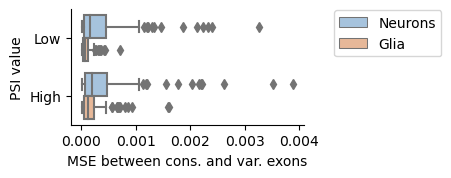

In [15]:
plt.figure(figsize=[3,1.5])
sns.boxplot(data=pd.concat((HPC_mse_neur2, HPC_mse_glia2)),
            x='value', y='variable', hue='cell type',
           palette=['#9DC3E6', '#F4B68C'])
sns.despine()
plt.xlabel('MSE between cons. and var. exons')
plt.ylabel('PSI value')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [16]:
FC_mse_neur = pd.read_csv('../../PSI_prediction/Zenodo/Human/FC/RBP/mse_neur.csv', index_col=0)
FC_mse_glia = pd.read_csv('../../PSI_prediction/Zenodo/Human/FC/RBP/mse_glia.csv', index_col=0)

# Only keep exons with at least 50 exons in every category
tk = (FC_mse_neur['Exons low var'] > 50) & (FC_mse_glia['Exons low var'] > 50) & (FC_mse_glia['Exons high var'] > 50) & (FC_mse_neur['Exons high var'] > 50)
FC_mse_neur = FC_mse_neur[tk]
FC_mse_glia = FC_mse_glia[tk]

FC_mse_glia2 = FC_mse_glia[['Low', 'High']].melt()
FC_mse_glia2['cell type'] = 'Glia'

FC_mse_neur2 = FC_mse_neur[['Low', 'High']].melt()
FC_mse_neur2['cell type'] = 'Neurons'

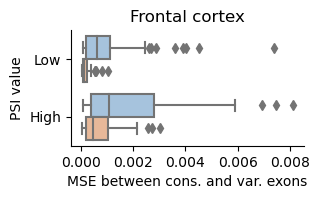

In [17]:
plt.figure(figsize=[3,1.5])
sns.boxplot(data=pd.concat((FC_mse_neur2, FC_mse_glia2)),
            x='value', y='variable', hue='cell type',
           palette=['#9DC3E6', '#F4B68C'])
plt.legend([], [], frameon=False)
sns.despine()
plt.xlabel('MSE between cons. and var. exons')
plt.ylabel('PSI value')
plt.title('Frontal cortex')
# plt.savefig('../../Evaluate models/Figures/boxplot_RBP_FC.pdf', bbox_inches='tight')
plt.show()

### Check whether the difference between neurons and glia is significant

In [18]:
from scipy.stats import wilcoxon

print(wilcoxon(FC_mse_glia2[FC_mse_glia2['variable'] == 'Low']['value'], FC_mse_neur2[FC_mse_neur2['variable'] == 'Low']['value']))
print(wilcoxon(FC_mse_glia2[FC_mse_glia2['variable'] == 'High']['value'], FC_mse_neur2[FC_mse_neur2['variable'] == 'High']['value']))

print(wilcoxon(HPC_mse_glia2[HPC_mse_glia2['variable'] == 'Low']['value'], HPC_mse_neur2[HPC_mse_neur2['variable'] == 'Low']['value']))
print(wilcoxon(HPC_mse_glia2[HPC_mse_glia2['variable'] == 'High']['value'], HPC_mse_neur2[HPC_mse_neur2['variable'] == 'High']['value']))



WilcoxonResult(statistic=216.0, pvalue=3.578079338965863e-08)
WilcoxonResult(statistic=105.0, pvalue=4.0311466518183515e-10)
WilcoxonResult(statistic=473.0, pvalue=8.982839066503265e-15)
WilcoxonResult(statistic=192.0, pvalue=9.51518447580423e-18)
